In [1]:
# Re-implement using pure shapely + rasterio (no geopandas) to avoid array-interface issues
import os, re, json, glob, math, warnings
import sys
import geopandas as gpd
import pathlib
from dataclasses import dataclass
import numpy as np
import pandas as pd
import rasterio
from rasterio.enums import Resampling
from rasterio.features import shapes, rasterize
from shapely.geometry import shape as shp_shape, mapping, Polygon, MultiPolygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, binary_closing, binary_fill_holes, label
import xml.etree.ElementTree
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
raw_fold_drive = "G"

if sys.platform == 'darwin':
    print('mac')
    raw_fold = pathlib.Path('/users/ink/Google Drive/My Drive/WORK/Milford/Planet/')
else:
    print('pc')
    raw_fold = pathlib.Path(f'{raw_fold_drive}:/My Drive/WORK/Milford/Planet/')



mac


In [4]:
def _coeffs_from_xml(xml_path: pathlib.Path) -> dict[int, float]:
    """Return {band_index(1-based): reflectanceCoefficient} from a Planet XML."""
    coeffs = {}
    try:
        root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
        for node in root.findall('.//{*}bandSpecificMetadata'):
            b = node.find('.//{*}bandNumber')
            c = node.find('.//{*}reflectanceCoefficient')
            if b is not None and c is not None:
                try:
                    coeffs[int(b.text.strip())] = float(c.text.strip())
                except Exception:
                    pass
    except Exception:
        pass
    return coeffs

def scale_with_xml(
    masked_raster: np.ndarray,
    xml_path: str | pathlib.Path,
    band_index: int | None = None,
    out_tif: str | pathlib.Path | None = None,
    template_tif: str | pathlib.Path | None = None
    ) -> np.ndarray: # type: ignore
        """Scale a masked raster using Planet reflectance coefficients from XML.
        
        Parameters
        ----------
        masked_raster : np.ndarray
            Your raster as a NumPy array. NaNs are preserved. Can be 2D (single-band)
            or 3D (bands, rows, cols). If 3D, scaling is applied per-band when possible.
        xml_path : str or Path
            Path to the Planet metadata XML containing <reflectanceCoefficient> per band.
        band_index : int, optional
            1-based band index whose coefficient should be used. Required if masked_raster is 2D
            and you want a specific band's coefficient. If masked_raster is 3D and band_index is None,
            the function attempts to scale each band i with coefficient (i+1).
        out_tif : str or Path, optional
            If given, write a GeoTIFF of the scaled raster (requires template_tif for geo metadata).
        template_tif : str or Path, optional
            A GeoTIFF to copy georeferencing/transform/profile from when writing out_tif.
        
        Returns
        -------
        np.ndarray
            Scaled raster (float32), preserving NaNs.
        """
        coeffs = _coeffs_from_xml(pathlib.Path(xml_path))
        arr = masked_raster.astype('float32', copy=True)
        
        if arr.ndim == 2:
            if band_index is None:
                raise ValueError("For a single-band array, provide band_index (1-based) to select a coefficient.")
            coeff = coeffs.get(int(band_index))
            if coeff is None:
                scaled = arr
            else:
                finite = np.isfinite(arr)
                scaled = np.full_like(arr, np.nan, dtype='float32')
                scaled[finite] = arr[finite] * float(coeff)
        elif arr.ndim == 3:
            scaled = np.full_like(arr, np.nan, dtype='float32')
            bands = arr.shape[0]
            for i in range(bands):
                c = coeffs.get(i+1)
                if c is None:
                    scaled[i] = arr[i]
                else:
                    finite = np.isfinite(arr[i])
                    scaled[i, finite] = arr[i, finite] * float(c)
        else:
            raise ValueError("masked_raster must be 2D or 3D.")

        if out_tif is not None:
            if template_tif is None:
                raise ValueError("template_tif is required when writing an output GeoTIFF.")
            with rasterio.open(template_tif) as tmpl:
                profile = tmpl.profile.copy()
                if scaled.ndim == 2:
                    profile.update(count=1, dtype='float32', nodata=np.nan)
                    with rasterio.open(out_tif, 'w', **profile) as dst:
                        dst.write(scaled, 1)
                else:
                    profile.update(count=scaled.shape[0], dtype='float32', nodata=np.nan)
                    with rasterio.open(out_tif, 'w', **profile) as dst:
                        dst.write(scaled)
        return scaled

def parse_date_from_path(path):
    base = os.path.basename(path)
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", base)
    if m:
        return pd.to_datetime(m.group(1)).date()
    js = re.sub(r"\.tif$", "_metadata.json", path)
    if os.path.exists(js):
        try:
            meta = json.load(open(js))
            acq = meta.get("properties", {}).get("acquired")
            if acq: return pd.to_datetime(acq).date()
        except Exception: pass
    return None

def get_ndvi(src, mask=None, xml=None):
    red = src.read(6).astype("float32")
    nir = src.read(8).astype("float32")
    if mask is not None:
        red = np.where(mask, red, np.nan)
        nir = np.where(mask, nir, np.nan)
    if xml is not None:
        red = scale_with_xml(red, xml_path=xml, band_index=6)
        nir = scale_with_xml(nir, xml_path=xml, band_index=8)
    den = nir + red
    ndvi = np.full_like(nir, np.nan, dtype="float32")
    valid = den != 0
    ndvi[valid] = (nir[valid] - red[valid]) / den[valid]
    return ndvi

def get_transform(src):
    transform = src.transform
    crs = src.crs
    xres = transform.a
    yres = -transform.e if transform.e < 0 else transform.e
    pixel_size = (xres, yres)
    return transform, crs, pixel_size

def read_udm_mask(udm_path:pathlib.Path):
    with rasterio.open(udm_path) as src:
        udm = src.read(1)
        mask = (udm == 1)
    return mask

def make_ndvi(composite_path:pathlib.Path, 
                    xml_path: pathlib.Path | None = None, 
                    udm_path: pathlib.Path | None = None):
    mask = read_udm_mask(udm_path) 
    with rasterio.open(composite_path) as src:
        ndvi = get_ndvi(src, mask=mask, xml=xml_path)
        transform, crs, pixel_size = get_transform(src)
        profile = src.profile.copy()
        profile.update(count=1, dtype="float32", nodata=np.nan)
        return ndvi, profile, transform, crs, pixel_size






def polygon_metrics(poly):
    A = poly.area
    Pp = poly.length
    if Pp==0: return 0.0, 0.0
    circ = 4*np.pi*A/(Pp*Pp)
    r_equiv = np.sqrt(A/np.pi)
    return float(circ), float(r_equiv)

def raster_mask_from_ndvi(ndvi, thresh, min_pixels):
    
    m = (ndvi>=thresh) & np.isfinite(ndvi)
    m = binary_opening(m, structure=np.ones((3,3)))
    m = binary_closing(m, structure=np.ones((5,5)))
    m = binary_fill_holes(m)
    lab, n = label(m) # type: ignore
    if n>0:
        cnt = np.bincount(lab.ravel())
        small = np.isin(lab, np.where(cnt<min_pixels)[0])
        m[small] = False
    return m

def zonal_ndvi(ndvi, polys, transform):
    ids = list(range(1, len(polys)+1))
    lid = rasterize(
        shapes=[(mapping(g), pid) for g, pid in zip(polys, ids)],
        out_shape=ndvi.shape,
        transform=transform,
        fill=0, dtype="int32", all_touched=False
    )
    rows = []
    for pid in ids:
        m = (lid==pid)
        if m.any():
            v = ndvi[m]
            rows.append(dict(pivot_id=pid,
                             ndvi_mean=float(np.nanmean(v)),
                             ndvi_p50=float(np.nanpercentile(v,50)),
                             ndvi_p90=float(np.nanpercentile(v,90)),
                             n_pix=int(np.isfinite(v).sum())))
        else:
            rows.append(dict(pivot_id=pid, ndvi_mean=np.nan, ndvi_p50=np.nan, ndvi_p90=np.nan, n_pix=0))
    return pd.DataFrame(rows)


In [6]:
for tif in raw_fold.glob("*composite.tif"):
    udm_path = pathlib.Path(str(tif)[:-4] + "_udm2.tif")
    xmls = list(raw_fold.glob("*.xml"))
    for xml in xmls:
        matches = []
        dt = parse_date_from_path(tif)
        strdate = f"{dt:%Y%m%d}"
        if strdate in str(xml):
            matches.append(xml)
        xml_path = matches[0] if matches else None
        if xml_path:
            print(strdate)
            xml_path = pathlib.Path(xml_path)
    if udm_path.exists():
        print(tif)
        dt = parse_date_from_path(tif)
        ndvi, profile, transform, crs, pixel_size = make_ndvi(tif, xml_path=xml_path, udm_path=udm_path)
        print(f"NDVI: {ndvi}, Profile: {profile}, Transform: {transform}, CRS: {crs}, Pixel Size: {pixel_size}")
        out_tif = tif.parents[0] / f"{dt:%Y%m%d}_ndvi.tif"
        with rasterio.open(out_tif, 'w', **profile) as dst:
            dst.write(ndvi, 1)


20240809
20240809
20240809
/users/ink/Google Drive/My Drive/WORK/Milford/Planet/2024-08-09_strip_7497591_composite.tif
NDVI: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]], Profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 3819, 'height': 6538, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS

In [7]:
from rasterstats import zonal_stats

zonal_dfs = {}
polys = gpd.read_file("wrlu.geojson").to_crs("EPSG:32612")
for ndvi in raw_fold.glob("*_ndvi.tif"):
    dt =str(ndvi.stem).split("_")[0]
    ndvi_vals = zonal_stats(polys,
                                str(ndvi), 
                                stats="mean")
    ndvis = [v['mean'] for v in ndvi_vals]
    zonal_dfs[dt] = ndvis

<Axes: title={'center': 'NDVI Time Series for 44587'}, xlabel='Date', ylabel='NDVI'>

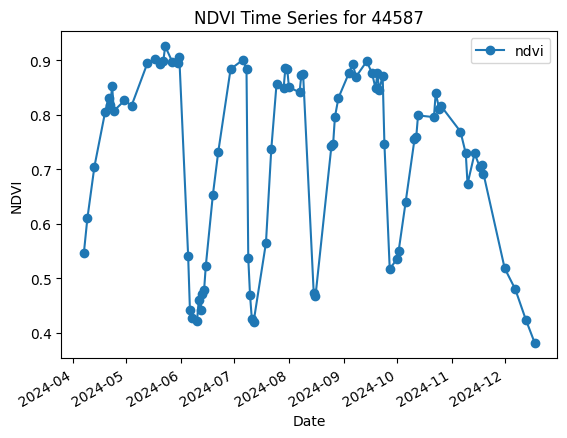

In [8]:
ndvi_df = pd.DataFrame.from_dict(zonal_dfs, orient="columns")
pl = polys['OBJECTID'].to_dict()
ndvi_df['OBJECTID'] = ndvi_df.index.map(pl)
ndvi_df = ndvi_df.set_index('OBJECTID')
ndvi_df = ndvi_df.stack().rename("ndvi").reset_index().rename(columns={'level_1':'date'})
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df = ndvi_df.set_index(['OBJECTID', 'date']).sort_index()

id = 44587
ndvi_df.loc[id].plot(marker='o', 
                       title=f"NDVI Time Series for {id}", 
                       ylabel="NDVI", 
                       xlabel="Date")

In [9]:
ndvi_df.to_csv("wrlu_ndvi_timeseries.csv")